# HARUN EREN MUTLU   270201089

# SERDAR SERTGÖZ   260201030

In [1]:
import os
import re
import nltk
import string
import numpy as np
import contractions
import pandas as pd
import networkx as nx
import multiprocessing
from sklearn import tree
from string import digits
from gensim import corpora
from textblob import TextBlob
from nltk import word_tokenize
import matplotlib.pyplot as plt
from autocorrect import Speller
from nltk.corpus import wordnet
from wordcloud import WordCloud
import matplotlib.style as style
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from nltk.stem import PorterStemmer
from sklearn.metrics import roc_curve
from gensim.models.ldamodel import LdaModel
from nltk.tokenize import WordPunctTokenizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from nltk.tokenize import sent_tokenize,word_tokenize
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# PART A

### To be able to parse all of the files

In [46]:
def get_files(path):
    return os.listdir(path)

### Cleaning punctuation

In [4]:
def clean(word):
    word2 = word.translate(re.sub(r'\d+', '', word).maketrans('', '', string.punctuation)).lower()
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

### Cleaning numbers

In [5]:

delete_words = set(nltk.corpus.words.words())

def clean_sent(sent):
    return " ".join(w for w in nltk.wordpunct_tokenize(sent) \
     if w.lower() in delete_words or not w.isalpha())

### Deleting outliers

In [6]:
def isValid(word):
    if len(word) == 2 and word[1] == 'a':
        return False
    return True

### Helping function for pos tagging

In [7]:
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

### Function that cleans document

We used more than 4 preprocessing methods.

Regular Expression Stemmer

Tokenization

Pos Tagging

Lemmatization

Spell Correction

Stop Word Removal

In [8]:
def clear_document(sentences):
    spell = Speller(lang='en') #spell correction
    new_words = ''
    lemmatizer = WordNetLemmatizer()
    for sentence in sentences:
        new_words += sentence.strip()
    new_words = clean(new_words)# regexp stemmer (puctuation cleaning)
    tokinezed = word_tokenize(new_words) #tokenization
    tags = nltk.pos_tag(tokinezed) #pos tagging
    correct_sentence = []
    for i in tags:
        position = get_wordnet_pos(i[1])
        if position == '':
            correct_sentence.append(lemmatizer.lemmatize(word=i[0]))  # lemmatization
        else:
            correct_sentence.append(lemmatizer.lemmatize(word=i[0], pos=position))  # lemmatization 
    correct_sentence = [spell(i) for i in correct_sentence] #spell correction
    stop_words = []
    stops = stopwords.words('english') #stop word removal
    [stop_words.append(word.replace("'", '') ) for word in stops]
    stop_words = list(set(stop_words))
    filtered_words = list(map(clean_sent, correct_sentence))
    filtered_words = [word for word in filtered_words if word not in stops and isValid(word)]
    while(True):
        if '' in filtered_words:
            filtered_words.remove('')
        else:
            break
    return ' '.join(filtered_words)

In [9]:
def clean_document(fileName):
    with open(fileName[0]) as f:
        words = f.readlines()
        cleaned_document = clear_document(words)
    with open(fileName[1],"w") as f:
        f.write(cleaned_document)

## We commanded this part because it takes some time to do cleaning and we already saved cleaned parts it reads all the files clean them and save cleaned documents

In [10]:
# path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
# path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
# for i in range(2):
#     path = path_list[i]
#     path_2 = path_list_2[i]
#     files = get_files(path)
#     filenames = [(path + file, path_2+file) for file in files]
#     with multiprocessing.Pool(20) as p:
#         # Use the pool to read all the files in parallel
#         p.map(clean_document, filenames)

# PART B

## Reading Cleaned Dataset

In [77]:
path_list_2 = ['cleaned/pos/', 'cleaned/neg/']
all_documents = []
sentiments = []
for i in range(2):
    path = path_list_2[i]
    files = get_files(path)
    for file in files:
        with open(path+file) as f:
            sentence = f.readline()
        all_documents.append(sentence)
        sentiments.append(path[-4:-1])

### Creating the dataframe

In [149]:
df = pd.DataFrame(columns=['text'], data=all_documents)

# Part B.1

### Extracting 4 features

We extracted 

Number of words

Polarity

Subjectivity

Number of Letters

In [150]:
df['number_of_words'] = df['text'].apply(lambda x : len(TextBlob(str(x)).words))
df['polarity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
df['subjectivity'] = df['text'].apply(lambda x : TextBlob(str(x)).sentiment.subjectivity)
df['number_of_letters'] = df['text'].apply(lambda x: sum([len(i) for i in x.split(' ')]))

# The Dataframe

In [151]:
df

,text,number_of_words,polarity,subjectivity,number_of_letters
0,assume nothing phrase perhaps one used first i...,376,0.167592,0.647744,2038
1,plot male model also dumb impressionable reaso...,286,0.025651,0.559099,1601
2,actually fan original flick name star mill twi...,717,0.189720,0.537842,3945
3,movie thats highly build human show review boa...,184,0.064375,0.360104,970
4,good hunt two movie one independent take strug...,145,0.207433,0.499777,909
...,...,...,...,...,...
1995,synopsis meteorite desert community college pr...,137,0.119066,0.555123,878
1996,anniversary slaying love best friend still bes...,252,0.148363,0.598198,1400
1997,coincide emerge popularity movie deal anything...,155,0.014219,0.464103,935
1998,highflying hong style make way classic pretty ...,209,-0.047128,0.451001,1202


# Part B.2

Creating Bag of Words

In [15]:
bag_of_words_model = CountVectorizer(max_features=10)

### Finding 10 most frequently occurring words 

In [16]:
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = sorted(bag_of_words_model.vocabulary_)
bag_of_word_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,6,2,1,3,2,0,2,1,6,3
1,2,6,3,1,0,4,1,4,1,4
2,1,18,2,2,5,7,7,4,12,7
3,1,4,1,3,2,0,1,6,0,1
4,1,2,0,0,5,2,1,1,1,0


## Creating TF-IDF

In [17]:
tfidf_model = TfidfVectorizer(max_features=10)
tfidf_df = pd.DataFrame(tfidf_model.fit_transform(all_documents).todense())
tfidf_df.columns = tfidf_model.get_feature_names_out()
tfidf_df.head()

,character,film,get,go,good,like,make,movie,one,see
0,0.620535,0.171225,0.101604,0.320219,0.217368,0.000000,0.191307,0.092488,0.523057,0.326748
1,0.216574,0.537834,0.319149,0.111760,0.000000,0.415934,0.100153,0.387354,0.091276,0.456156
2,0.044053,0.656394,0.086556,0.090931,0.231469,0.296113,0.285204,0.157581,0.445590,0.324748
3,0.131662,0.435953,0.129347,0.407652,0.276720,0.000000,0.121771,0.706450,0.000000,0.138655
4,0.163510,0.270704,0.000000,0.000000,0.859143,0.314024,0.151228,0.146223,0.137825,0.000000


# PART B.3

## We Chose Bag Of Words

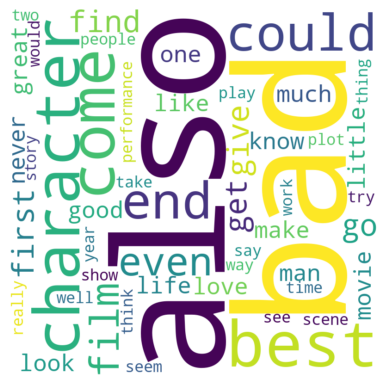

In [18]:
bag_of_words_model = CountVectorizer(max_features=50)
bag_of_word_df = pd.DataFrame(bag_of_words_model.fit_transform(all_documents).todense())
bag_of_word_df.columns = bag_of_words_model.get_feature_names_out()
bests2= list(bag_of_word_df.columns)
wordcloud = WordCloud(width = 800, height = 800, 
    background_color ='white', 
    max_words=50,
    stopwords = [],
    min_font_size = 10).generate(' '.join(bests2))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud.png')
plt.show()

# PART B.4

## Function to implement Roc Curve

In [130]:
def plot_roc_curve(test_df, test_label, algorithm_name):
    false_positive_rate1, true_positive_rate1, threshold1 = roc_curve(test_df['actual_cluster'], test_df[test_label])
    plt.subplots(1, figsize=(10,10))
    plt.title(f'Receiver Operating Characteristic - {algorithm_name}')
    plt.plot(false_positive_rate1, true_positive_rate1)
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

## Creating the values of documents 1 is positive 0 is negative

In [152]:
df['actual_cluster'] = [1 for _ in range(1000)] + [0 for _ in range(1000)]

### Scaling the features 

In [153]:
scaler = StandardScaler()
df[['number_of_words', 'polarity', 'subjectivity', 'number_of_letters']] = scaler.fit_transform(df.drop(['actual_cluster', 'text'], axis=1))
new_df = df.drop('text',axis=1)

### Scaled Dataframe

In [154]:
new_df

,number_of_words,polarity,subjectivity,number_of_letters,actual_cluster
0,0.486252,0.927312,2.220231,0.368216,1
1,-0.176975,-0.704613,0.722173,-0.190929,1
2,2.999145,1.181726,0.362930,2.808237,1
3,-0.928632,-0.259395,-2.640752,-0.998298,1
4,-1.216030,1.385375,-0.280345,-1.076348,1
...,...,...,...,...,...
1995,-1.274983,0.369396,0.654971,-1.116013,0
1996,-0.427527,0.706234,1.382920,-0.448110,0
1997,-1.142338,-0.836048,-0.883227,-1.043081,0
1998,-0.744402,-1.541365,-1.104643,-0.701452,0


# K-Means

/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` 

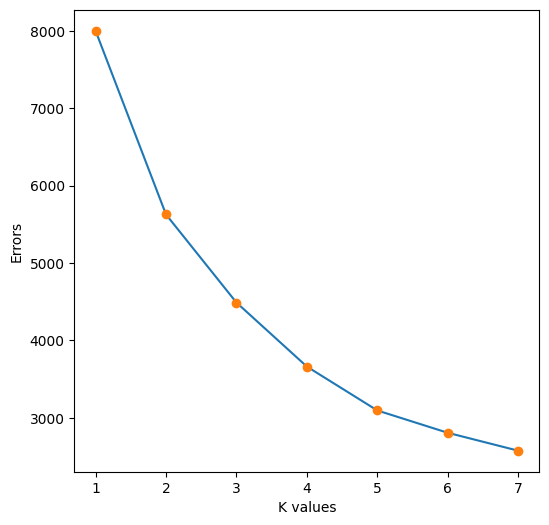

In [155]:
scores=[]
for k in [1,2,3,4,5,6,7]:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(new_df.drop(['actual_cluster'], axis=1).to_numpy())
    scores.append(-kmeans.score(new_df.drop(['actual_cluster'], axis=1).to_numpy()))
plt.figure(figsize=(6, 6))
plt.plot([k for k in range(1,8)], scores)
plt.plot([k for k in range(1,8)], scores, 'o')
plt.xlabel('K values')
plt.ylabel('Errors')
plt.show()

Root Mean Square Error (RMSE) :  0.432
Confusion matrix:
[359 223]
[641 777]
Accuracy: 0.568
Precision: 0.6168384879725086
F1: 0.45385587863463966


/Users/harunerenmutlu/miniforge3/envs/nlp/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


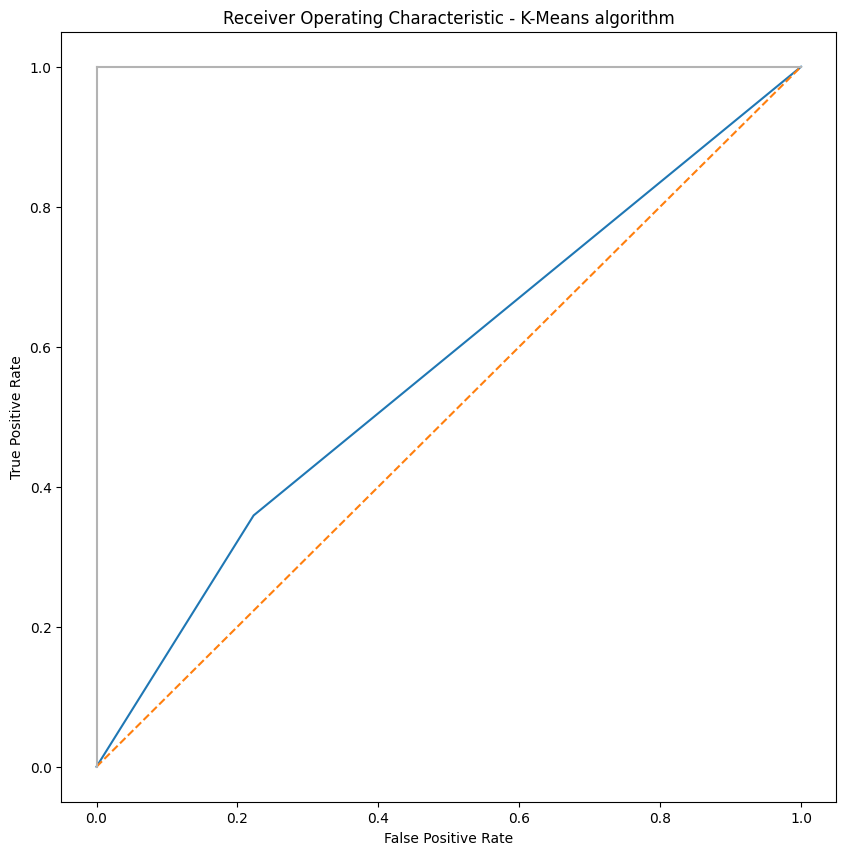

In [156]:
kmeans = KMeans(n_clusters=2)
kmeans.fit(new_df)
y_kmeans = kmeans.predict(new_df)
new_df['obtained_clusters'] = y_kmeans
tn_filter = (new_df["actual_cluster"]== 0) & (new_df["obtained_clusters"]<0.5)
fp_filter = (new_df["actual_cluster"]== 0) & (new_df["obtained_clusters"]>0.5)
fn_filter = (new_df["actual_cluster"]== 1) & (new_df["obtained_clusters"]<0.5)
tp_filter = (new_df["actual_cluster"]== 1) & (new_df["obtained_clusters"]>0.5)

tp = len(new_df.where(tp_filter).dropna())
fp = len(new_df.where(fp_filter).dropna())
tn = len(new_df.where(tn_filter).dropna())
fn = len(new_df.where(fn_filter).dropna())


precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
fp_rate = fp /(fp+tn)
accuracy = (tp+tn)/(tn+fn+tp+fp)

print("Root Mean Square Error (RMSE) : ",mean_squared_error(new_df['actual_cluster'],new_df['obtained_clusters']))
print('Confusion matrix:')
for i in np.array([[tp,fp], [fn,tn]]):
    print(i)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1: {f1}')
plot_roc_curve(test_df=new_df, test_label='obtained_clusters', algorithm_name='K-Means algorithm')

Root Mean Square Error (RMSE) :  0.18900303220725706
Confusion matrix:
[216  90]
[ 71 223]
Accuracy: 0.7316666666666667
Precision: 0.7058823529411765
F1: 0.7284991568296796


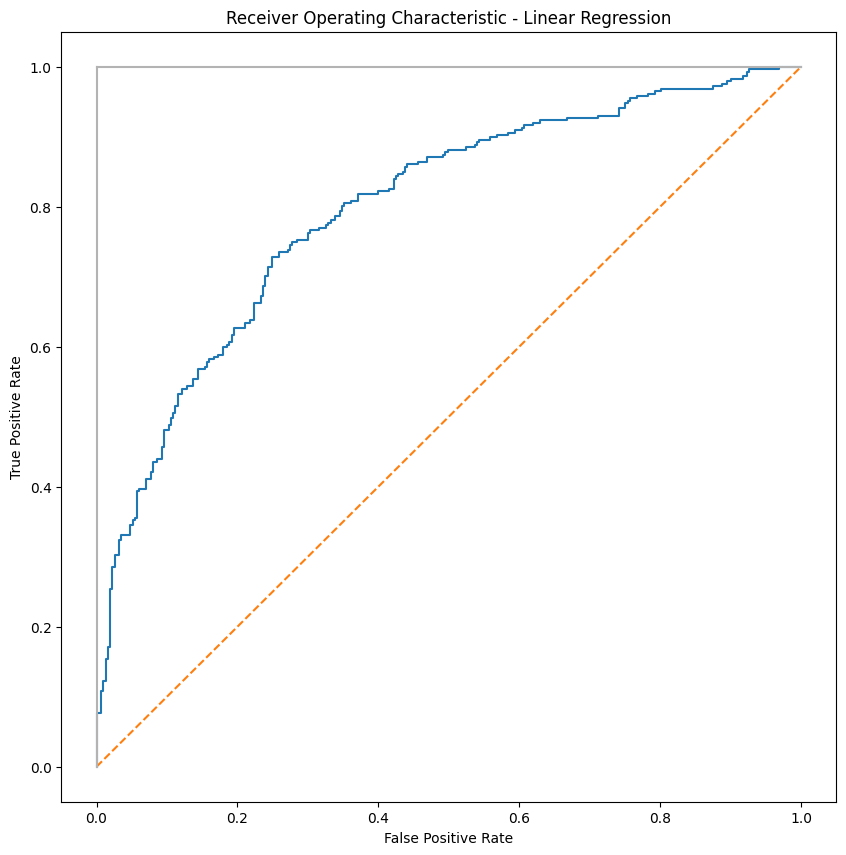

In [157]:
train_df, test_df = train_test_split(new_df, test_size =0.3)
linreg = LinearRegression()
linreg.fit(train_df.drop('actual_cluster', axis=1), train_df['actual_cluster'])

test_df['predicted_score_from_linear_regression'] = linreg.predict(test_df.drop('actual_cluster', axis=1))
test_df[['actual_cluster', 'predicted_score_from_linear_regression']]
tn_filter = (test_df["actual_cluster"]==0) & (test_df["predicted_score_from_linear_regression"]<0.5)
fp_filter = (test_df["actual_cluster"]== 0) & (test_df["predicted_score_from_linear_regression"]>0.5)
fn_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_score_from_linear_regression"]<0.5)
tp_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_score_from_linear_regression"]>0.5)
  
# filtering data
tp = len(test_df.where(tp_filter).dropna())
fp = len(test_df.where(fp_filter).dropna())
tn = len(test_df.where(tn_filter).dropna())
fn = len(test_df.where(fn_filter).dropna())


precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
fp_rate = fp /(fp+tn)
accuracy = (tp+tn)/(tn+fn+tp+fp)
print("Root Mean Square Error (RMSE) : ",mean_squared_error(test_df['actual_cluster'],test_df['predicted_score_from_linear_regression']))
print('Confusion matrix:')
for i in np.array([[tp,fp], [fn,tn]]):
    print(i)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1: {f1}')
plot_roc_curve(test_df=test_df, test_label='predicted_score_from_linear_regression', algorithm_name='Linear Regression')

Root Mean Square Error (RMSE) :  0.255
Confusion matrix:
[227  78]
[ 75 220]
Accuracy: 0.745
Precision: 0.7442622950819672
F1: 0.7479406919275122


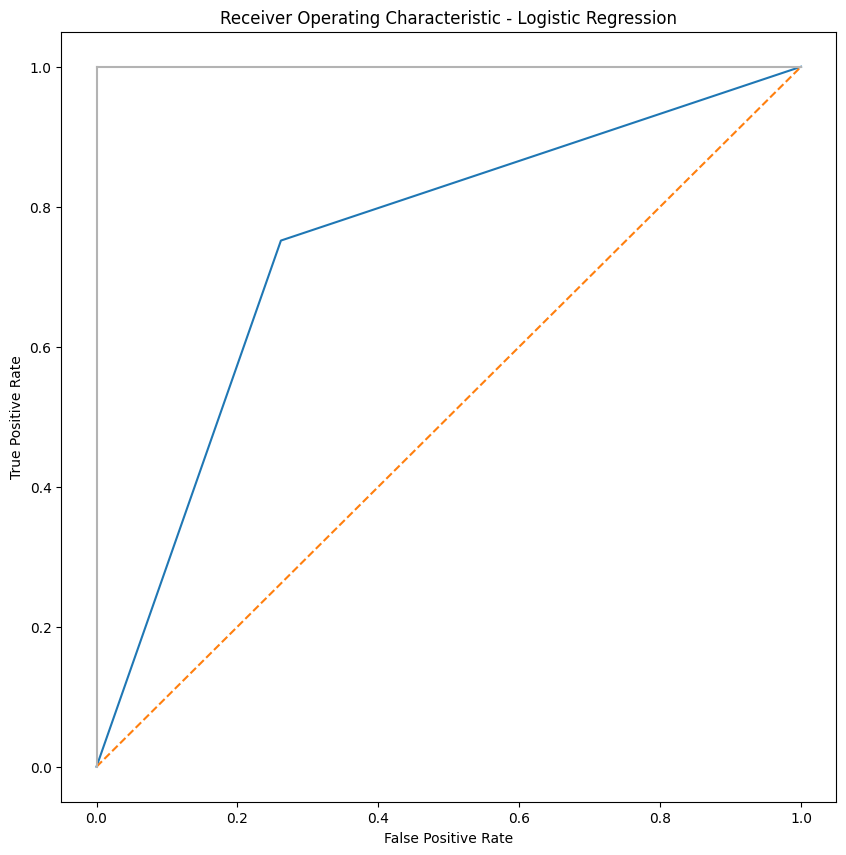

In [161]:

train_df, test_df = train_test_split(new_df,test_size =0.3)
param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2, 5, 10, 50], 'solver':['lbfgs', 'liblinear']}
logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=param_grid, cv=k, refit=True)

logreg.fit(train_df.drop('actual_cluster', axis=1), train_df['actual_cluster'])

test_df['predicted_labels_from_LogisticRegression'] = logreg.predict(test_df.drop('actual_cluster', axis=1))

tn_filter = (test_df["actual_cluster"]==0) & (test_df["predicted_labels_from_LogisticRegression"]<0.5)
fp_filter = (test_df["actual_cluster"]== 0) & (test_df["predicted_labels_from_LogisticRegression"]>0.5)
fn_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_labels_from_LogisticRegression"]<0.5)
tp_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_labels_from_LogisticRegression"]>0.5)
  
# filtering data
tp = len(test_df.where(tp_filter).dropna())
fp = len(test_df.where(fp_filter).dropna())
tn = len(test_df.where(tn_filter).dropna())
fn = len(test_df.where(fn_filter).dropna())

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
fp_rate = fp /(fp+tn)
accuracy = (tp+tn)/(tn+fn+tp+fp)

print("Root Mean Square Error (RMSE) : ",mean_squared_error(test_df['actual_cluster'],test_df['predicted_labels_from_LogisticRegression']))
print('Confusion matrix:')
for i in np.array([[tp,fp], [fn,tn]]):
    print(i)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1: {f1}')
plot_roc_curve(test_df=test_df, test_label='predicted_labels_from_LogisticRegression', algorithm_name='Logistic Regression')

In [159]:
train_df, test_df = train_test_split(df.drop(['text'], axis=1), test_size =0.3)
dtc = tree.DecisionTreeClassifier()
dtc = dtc.fit(train_df.drop('actual_cluster', axis=1), train_df['actual_cluster'])

test_df['predicted'] = dtc.predict(test_df.drop('actual_cluster', axis=1))

Root Mean Square Error (RMSE) :  0.37
Confusion matrix:
[180  99]
[123 198]
Accuracy: 0.63
Precision: 0.6451612903225806
F1: 0.6185567010309277


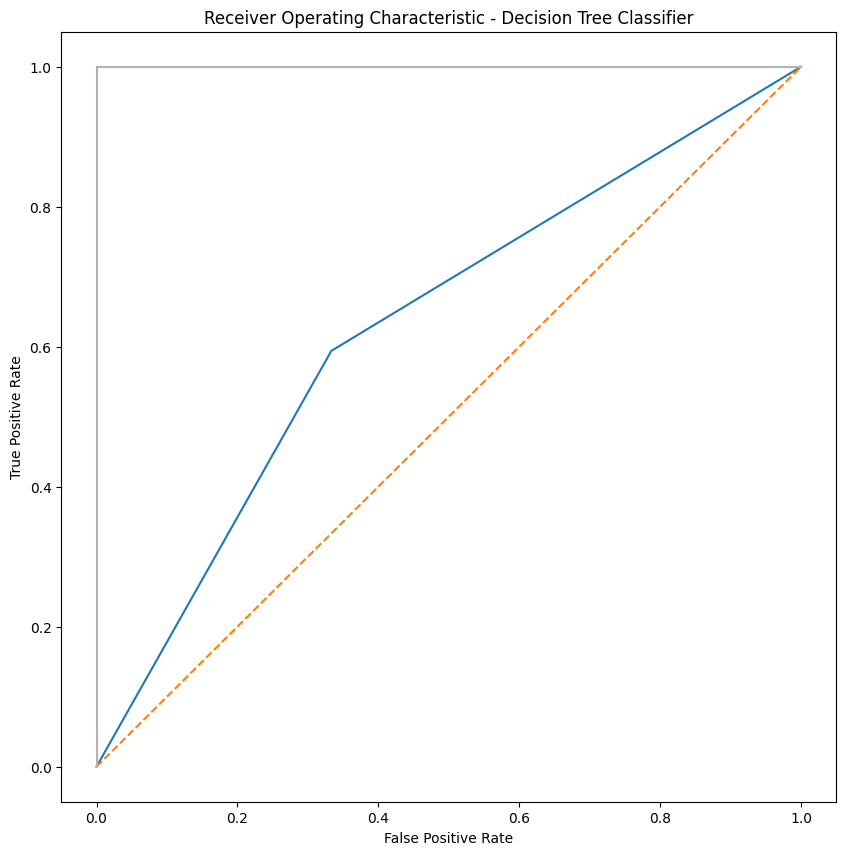

In [160]:
tn_filter = (test_df["actual_cluster"]==0) & (test_df["predicted"]==0)
fp_filter = (test_df["actual_cluster"]== 0) & (test_df["predicted"]== 1)
fn_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted"]== 0)
tp_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted"]== 1)
  
# filtering data
tp = len(test_df.where(tp_filter).dropna())
fp = len(test_df.where(fp_filter).dropna())
tn = len(test_df.where(tn_filter).dropna())
fn = len(test_df.where(fn_filter).dropna())

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)
fp_rate = fp /(fp+tn)
accuracy = (tp+tn)/(tn+fn+tp+fp)

print("Root Mean Square Error (RMSE) : ",mean_squared_error(test_df['actual_cluster'],test_df['predicted']))
print('Confusion matrix:')
for i in np.array([[tp,fp], [fn,tn]]):
    print(i)
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'F1: {f1}')
plot_roc_curve(test_df=test_df, test_label='predicted', algorithm_name='Decision Tree Classifier')

# PART C

In [290]:

df_lda = pd.DataFrame()
df_lda['text'] = df['text']
lists = df_lda.text.apply(word_tokenize).tolist()

In [291]:
dictionary = corpora.Dictionary(lists)
corpus = [dictionary.doc2bow(text) for text in lists]

## Calculating Coherence Score

In [292]:

def calculate_coherence_score(documents, dictionary, model):
    coherence_model = CoherenceModel(model=model,
                                    texts=documents,
                                    dictionary=dictionary,
                                    coherence='c_v')
    return coherence_model.get_coherence()
def get_coherence_values(start, stop):
    for num_topics in range(start, stop):
        print(f'\nCalculating coherence for {num_topics} topics')
        ldamodel = LdaModel(corpus,
                    num_topics = num_topics,
                    id2word=dictionary, passes=2)
        coherence = calculate_coherence_score(lists,
                                            dictionary,
                                            ldamodel)
        yield coherence

## To be able to determine the optimal number of topics

In [293]:
min_topics, max_topics = 2, 15
coherence_scores = list(get_coherence_values(min_topics, max_topics))


Calculating coherence for 2 topics

Calculating coherence for 3 topics

Calculating coherence for 4 topics

Calculating coherence for 5 topics

Calculating coherence for 6 topics

Calculating coherence for 7 topics

Calculating coherence for 8 topics

Calculating coherence for 9 topics

Calculating coherence for 10 topics

Calculating coherence for 11 topics

Calculating coherence for 12 topics

Calculating coherence for 13 topics

Calculating coherence for 14 topics


Text(0.5, 1.0, 'Coherence Scores')

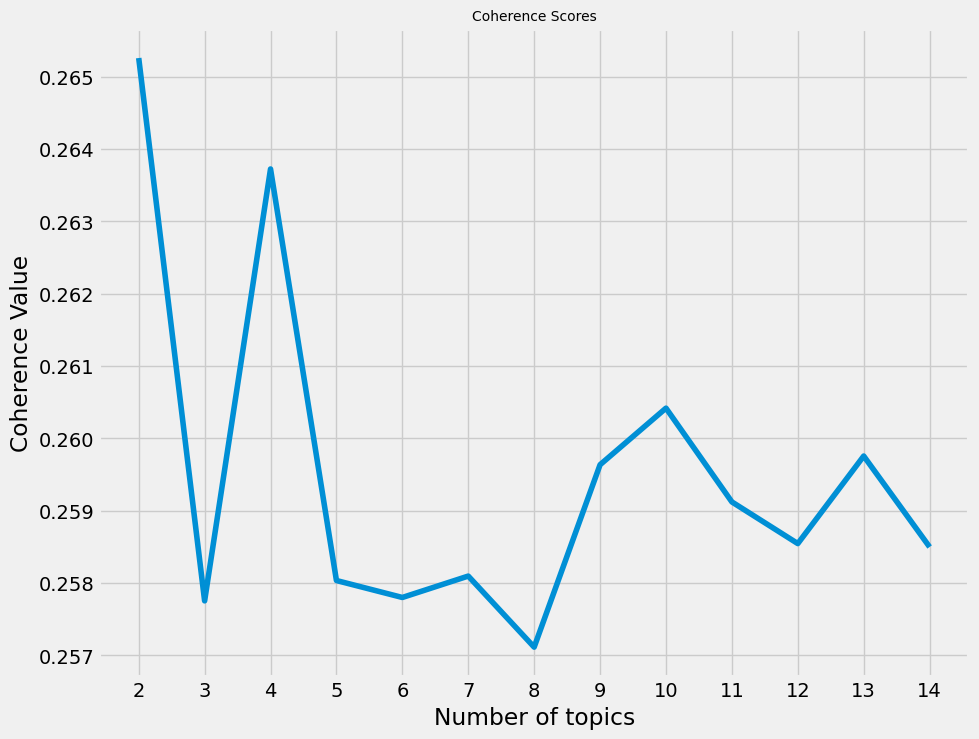

In [294]:
style.use('fivethirtyeight')
%matplotlib inline
x = [int(i) for i in range(min_topics, max_topics)]
ax = plt.figure(figsize=(10,8))
plt.xticks(x)
plt.plot(x, coherence_scores)
plt.xlabel('Number of topics')
plt.ylabel('Coherence Value')
plt.title('Coherence Scores', fontsize=10)

# 2 is the best for LDA

In [295]:
ldamodel = LdaModel(corpus, num_topics = 2, id2word=dictionary, passes=2)
coherence = calculate_coherence_score(lists, dictionary, ldamodel)

In [319]:
coherence

0.2636338670778873

### As we can see both LDA and K-Means state that there should be 2 topics. Our F1 score for K-Means was 0.46 and Our coherence score for LDA is 0.27. Normally, Lda generally gives more efficient results for Sentiment Analysis, but in this case K-Means performed better.

# Part D

In [3]:
CLEAN_PATTERN = r'[^a-zA-z\s]'
stop_words = stopwords.words('english')

def clean(word):
    word2 = word.translate(re.sub(CLEAN_PATTERN,'', word).maketrans('', '', string.punctuation)).lower()
    remove_digits = str.maketrans('', '', digits)
    return word2.translate(remove_digits)

def clean_sentence(sentence):
    sentence = [clean(word) for word in sentence ]
    sentence = (" ".join(w for w in sentence)).strip()
    sentence = sentence.split(" ")
    return [word for word in sentence ]

def clean_sentences(sentences):
    return [clean_sentence(sentence) for sentence in sentences ]

def lower(sentence):
    return [word.lower() for word in sentence]
    
def remove_stopwords(sentence):
    words = [word for word in sentence if word not in stop_words]
    return [word for word in words]

def tokenize_words(sentences):
    return [word_tokenize(sentence)
              for sentence in sentences]
              
def fix_contractions(sentences):
    return [contractions.fix(sentence) for sentence in sentences]

# Reading text files and store them in the list as seperate texts

In [4]:
path_list = ['review_polarity/txt_sentoken/pos/', 'review_polarity/txt_sentoken/neg/']
texts = [[],[]] # pos, neg
for i in range(2):
    path = path_list[i]
    files = os.listdir(path)
    for fileName in files:
        text = ""
        with open(path+fileName) as f:
            text = f.read()
        texts[i].append(text)

Store texts on the dataframe as raw text

In [5]:

pos_df = pd.DataFrame()
neg_df = pd.DataFrame()

pos_df["raw_text"] = texts[0]
neg_df["raw_text"] = texts[1]

We extracted sentences in the texts and words that aplied some preprocessing phases in the centences

In [6]:
pos_df['SentencesInArticle'] = pos_df.raw_text.apply(sent_tokenize)
pos_df['WordsInSentences'] = pos_df.SentencesInArticle \
              .apply(fix_contractions)\
              .apply(lower)\
              .apply(tokenize_words)\
              .apply(remove_stopwords)\
              .apply(clean_sentences)


neg_df['SentencesInArticle'] = neg_df.raw_text.apply(sent_tokenize)
neg_df['WordsInSentences'] = neg_df.SentencesInArticle \
              .apply(fix_contractions)\
              .apply(lower)\
              .apply(tokenize_words)\
              .apply(remove_stopwords)\
              .apply(clean_sentences)

In [7]:
dfs = [pos_df,neg_df]
dfs[0].head()

,raw_text,SentencesInArticle,WordsInSentences
0,assume nothing . \nthe phrase is perhaps one o...,"[assume nothing ., the phrase is perhaps one o...","[[assume, nothing], [the, phrase, is, perhaps,..."
1,plot : derek zoolander is a male model . \nhe ...,"[plot : derek zoolander is a male model ., he ...","[[plot, , derek, zoolander, is, a, male, model..."
2,i actually am a fan of the original 1961 or so...,[i actually am a fan of the original 1961 or s...,"[[i, actually, am, a, fan, of, the, original, ..."
3,a movie that's been as highly built up as the ...,[a movie that's been as highly built up as the...,"[[a, movie, that, is, been, as, highly, built,..."
4,""" good will hunting "" is two movies in one : ...","[ "" good will hunting "" is two movies in one :...","[[good, will, hunting, , is, two, movies, in, ..."


We read vectors from file. Used size 50

In [8]:
def load_glove_vectors(fn):
    print("Loading Glove Model")
    with open( fn,'r', encoding='utf8') as glove_vector_file:
        model = {}
        for line in glove_vector_file:
            parts = line.split()
            word = parts[0]
            embedding = np.array([float(val) for val in parts[1:]])
            model[word] = embedding
        print("Loaded {} words".format(len(model)))
    return model
glove_vectors = load_glove_vectors('glove.6B/glove.6B.50d.txt')

Loading Glove Model
Loaded 400000 words


In [9]:
VECTOR_SIZE = 50
EMPTY_VECTOR = np.zeros(VECTOR_SIZE)
def sentence_vector(sentence):
    if(len(sentence) == 0):
        return EMPTY_VECTOR
    return sum([glove_vectors.get(word, EMPTY_VECTOR)
                  for word in sentence])/len(sentence)
def sentences_to_vectors(sentences):
    return [sentence_vector(sentence)
              for sentence in sentences]

We added sentence vectors to datafram 

In [10]:
pos_df['SentenceVector'] = pos_df.WordsInSentences.apply(sentences_to_vectors)
        

neg_df['SentenceVector'] = neg_df.WordsInSentences.apply(sentences_to_vectors)


In [11]:
def similarity_matrix(sentence_vectors):
    sim_mat = np.zeros([len(sentence_vectors), len(sentence_vectors)])
    for i in range(len(sentence_vectors)):
        for j in range(len(sentence_vectors)):
            element_i = sentence_vectors[i].reshape(1,VECTOR_SIZE)
            element_j = sentence_vectors[j].reshape(1,VECTOR_SIZE)
            sim_mat[i][j] = cosine_similarity(element_i,
                                              element_j)[0,0]
    return sim_mat

We created similarity matrix and added to dataframe

In [12]:
pos_df['SimMatrix'] =  pos_df.SentenceVector.apply(similarity_matrix)

neg_df['SimMatrix'] =  neg_df.SentenceVector.apply(similarity_matrix)


In [13]:
def compute_graph(sim_matrix):
    nx_graph = nx.from_numpy_array(sim_matrix)
    scores = nx.pagerank_numpy(nx_graph)
    return scores

In [ ]:
pos_df['Graph'] = pos_df.SimMatrix.apply(compute_graph)

neg_df['Graph'] = neg_df.SimMatrix.apply(compute_graph)

In [15]:
def get_ranked_sentences(sentences, scores, n=3):
    top_scores = sorted(((scores[i],s)
                         for i,s in enumerate(sentences)),
                                reverse=True)
    top_n_sentences = [sentence
                        for score,sentence in top_scores[:n]]
    return " ".join(top_n_sentences)

We found summarized texts of raw texts with get_ranked_sentences function and added them to dataframe

In [16]:
pos_df['Summary'] = pos_df.apply(lambda d:get_ranked_sentences(d.SentencesInArticle,d.Graph), axis=1)

neg_df['Summary'] = neg_df.apply(lambda d:get_ranked_sentences(d.SentencesInArticle,d.Graph), axis=1)

pos_df.head()

,raw_text,SentencesInArticle,WordsInSentences,SentenceVector,SimMatrix,Graph,Summary
0,assume nothing . \nthe phrase is perhaps one o...,"[assume nothing ., the phrase is perhaps one o...","[[assume, nothing], [the, phrase, is, perhaps,...","[[0.55068, -0.073617, 0.1598, -0.2449599999999...","[[1.0, 0.8299718536919577, 0.7721077719899806,...","{0: 0.019503609450574725, 1: 0.022847092291976...","well , another popular phrase of the 90's is ""..."
1,plot : derek zoolander is a male model . \nhe ...,"[plot : derek zoolander is a male model ., he ...","[[plot, , derek, zoolander, is, a, male, model...","[[0.23455125000000004, 0.44996824999999996, -0...","[[0.9999999999999997, 0.8330312080920349, 0.78...","{0: 0.02712777015634996, 1: 0.0300324731593520...","if you thought the trailer was dumb , skip thi..."
2,i actually am a fan of the original 1961 or so...,[i actually am a fan of the original 1961 or s...,"[[i, actually, am, a, fan, of, the, original, ...","[[0.25361919999999993, 0.23047472, -0.12890895...","[[1.0, 0.9573955262843199, 0.9752319517256701,...","{0: 0.017877327550057245, 1: 0.017807174317796...","it's playful , and witty , and charming , and ..."
3,a movie that's been as highly built up as the ...,[a movie that's been as highly built up as the...,"[[a, movie, that, is, been, as, highly, built,...","[[0.2723627083333333, 0.15996545833333334, -0....","[[1.0, 0.9205696621088771, 0.9080363191551283,...","{0: 0.03774010163858645, 1: 0.0360202331202815...",that's no doubt -- it seems any movie with cri...
4,""" good will hunting "" is two movies in one : ...","[ "" good will hunting "" is two movies in one :...","[[good, will, hunting, , is, two, movies, in, ...","[[0.1672120666666667, 0.1717332222222223, -0.1...","[[1.0, 0.953665857777019, 0.9319960663846607, ...","{0: 0.10148343890609572, 1: 0.1003788061374531...","good will hunting "" exposes the lack of profou..."


We wrote the summarized texts to files

In [ ]:

paths = ['summarized_texts/pos_summarized.txt', 'summarized_texts/neg_summarized.txt']

for i in range(2):
    with open(paths[i],"w") as f:
        for row in range(len(dfs[i])):
            f.write(str(dfs[i].loc[row].Summary) + "\n")

# Part E

In [33]:
df.head()

,text,number_of_words,polarity,subjectivity,number_of_letters,actual_cluster
0,assume nothing phrase perhaps one used first i...,376,0.167592,0.647744,2038,1
1,plot male model also dumb impressionable reaso...,286,0.025651,0.559099,1601,1
2,actually fan original flick name star mill twi...,717,0.189720,0.537842,3945,1
3,movie thats highly build human show review boa...,184,0.064375,0.360104,970,1
4,good hunt two movie one independent take strug...,145,0.207433,0.499777,909,1


We choosed Polarity 

In [92]:
# We have used all_documnets from Part A to create new dataframe
df_part5 = pd.DataFrame(columns=['text'], data=all_documents)
df_part5['polarity'] = df_part5['text'].apply(lambda x : TextBlob(str(x)).sentiment.polarity)
df_part5['actual_cluster'] = df['actual_cluster']
df_part5


,text,polarity,actual_cluster
0,assume nothing phrase perhaps one used first i...,0.167592,1
1,plot male model also dumb impressionable reaso...,0.025651,1
2,actually fan original flick name star mill twi...,0.189720,1
3,movie thats highly build human show review boa...,0.064375,1
4,good hunt two movie one independent take strug...,0.207433,1
...,...,...,...
1995,synopsis meteorite desert community college pr...,0.119066,0
1996,anniversary slaying love best friend still bes...,0.148363,0
1997,coincide emerge popularity movie deal anything...,0.014219,0
1998,highflying hong style make way classic pretty ...,-0.047128,0


In [122]:

train_df, test_df = train_test_split(df_part5.drop(['text'],axis=1),test_size =0.2)

In [123]:

param_grid = {'C': [0.01, 0.05, 0.1, 0.5, 1.0, 2, 5, 10, 50], 'solver':['lbfgs', 'liblinear']}
logreg = GridSearchCV(LogisticRegression(max_iter=1000), param_grid=param_grid, cv=k, refit=True)

logreg.fit(train_df.drop('actual_cluster', axis=1), train_df['actual_cluster'])

test_df['predicted_labels_from_LogisticRegression'] = logreg.predict(test_df.drop('actual_cluster', axis=1))

tn_filter = (test_df["actual_cluster"]==0) & (test_df["predicted_labels_from_LogisticRegression"]<0.5)
fp_filter = (test_df["actual_cluster"]== 0) & (test_df["predicted_labels_from_LogisticRegression"]>0.5)
fn_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_labels_from_LogisticRegression"]<0.5)
tp_filter = (test_df["actual_cluster"]== 1) & (test_df["predicted_labels_from_LogisticRegression"]>0.5)
  
# filtering data
tp = len(test_df.where(tp_filter).dropna())
fp = len(test_df.where(fp_filter).dropna())
tn = len(test_df.where(tn_filter).dropna())
fn = len(test_df.where(fn_filter).dropna())


accuracy = (tp+tn)/(tn+fn+tp+fp)

print(f'Accuracy: {accuracy}')

precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2*precision*recall/(precision+recall)

print(f'F1: {f1}')

Accuracy: 0.735
F1: 0.7401960784313725
